In [ ]:
# When running in google colab

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Step 1: Importing library_classifier.ipynb 

%run '/content/drive/MyDrive/Research project 1/library_classifier.ipynb'


In [ ]:
# Connecting to TPU via Google Colab (needed only when running Bert model)

try:
  # TPU detection
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
  
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
print("All devices: ", tf.config.list_logical_devices('TPU'))


Running on TPU  ['10.42.225.186:8470']


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [3]:
# Step 2: Creating train, dev and test datasets by accessing create_df() function.
# It returns a list containing 3 dataframes such as train, dev and test

df=create_df()

<ipython-input-2-d8715050cfd8>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('not_of_interest', inplace=True, axis=1)
<ipython-input-2-d8715050cfd8>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["non-psych"].fillna("psych", inplace = True)


train_df size:  3946
dev_df size:  2959
test_df size:  2960
verb count in train, dev & test:  64 64 64


In [ ]:
"""
Please note that, Step 3 to Step 10 has to be run for each dataset(train, dev and test) 
"""

In [ ]:
# Step 3: Getting the inputs for Bert model by accessing get_bert_input() function
# It returns a list containing input_ids and verb position in tokenized words

bert_input=get_bert_input(df[0]["Sentence"],df[0]["Token_ID"])

Maximum no. of tokens 416
Output of Bert tokenizer for sample sentence: {'input_ids': [3, 388, 1377, 6739, 1312, 941, 229, 2210, 26918, 221, 252, 10159, 21, 4409, 26935, 5842, 2973, 19811, 26690, 15423, 12126, 26899, 1610, 26914, 4], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
Input_ids:  [3, 388, 1377, 6739, 1312, 941, 229, 2210, 26918, 221, 252, 10159, 21, 4409, 26935, 5842, 2973, 19811, 26690, 15423, 12126, 26899, 1610, 26914, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
# Step 4: Getting the Bert embeddings get_bert() function
# It returns 3d tensor containing bert embeddings

with tpu_strategy.scope():
    bert_embed=get_bert(bert_input[0])

Some layers from the model checkpoint at bert-base-german-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-german-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Last hidden state output of Bert model tf.Tensor(
[[ 1.577835    0.9595791   1.1689122  ...  0.10631397 -0.86703235
  -0.14076677]
 [ 0.4878976   0.19210257  1.1432971  ...  0.5966799  -0.14479811
  -0.09620293]
 [ 0.48839146  0.53696865  1.2179929  ...  0.15996125  0.0617578
   0.72462606]
 ...
 [ 1.8279674   0.49318236  1.1511029  ...  0.45383006  0.11099829
   0.11074064]
 [ 1.6782169   0.6976241   1.2471346  ...  0.39308712 -0.11304773
   0.12047403]
 [ 1.6343844   0.96831286  0.9070688  ...  0.3856811   0.18439278
   0.23390833]], shape=(416, 768), dtype=float32)


In [ ]:
# Step 5: Selecting only sentence & verb embeddings from the bert embeddings by accessing  get_sent_and_verb_embed() function
# It returns 3d tensor containing CLS embedding and verb embedding

sent_and_verb_embed = get_sent_and_verb_embed(bert_embed,df[0]["Sentence"],bert_input[1])

bert embedding shape (6, 768)
sample embedding tf.Tensor(
[[ 1.577835    0.9595791   1.1689122  ...  0.10631397 -0.86703235
  -0.14076677]
 [-1.0247573   1.4031551   0.6949277  ... -0.95498884 -0.8156243
  -1.9968821 ]
 [-0.8436365   0.9639743   0.9803964  ... -0.311114   -1.1016244
  -2.204798  ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]], shape=(6, 768), dtype=float32)


In [ ]:
# Step 6: Saving the sent & verb embeddings in pickle

with open('/content/drive/MyDrive/Research project 1/Bert embeddings/test_embed.pkl', 'wb') as f:
  pickle.dump(sent_and_verb_embed, f)



In [4]:
# Step 7: Loading embeddings from pickle

with open('/content/drive/MyDrive/Research project 1/Bert embeddings/test_embed.pkl', 'rb') as f:
  test_embed = pickle.load(f)


In [5]:
print("sample bert embeddings from pickle", test_embed[0])

sample bert embeddings from pickle tf.Tensor(
[[ 1.3655096   1.0511383   1.0979121  ...  0.08296822 -0.8825487
  -0.2308129 ]
 [ 0.57203984  0.27268237 -0.174551   ... -0.02538614  0.5935935
  -0.2730767 ]
 [-0.03913849  0.81382996  0.36051887 ...  0.29497954 -0.32289433
  -0.29149848]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]], shape=(6, 768), dtype=float32)


In [ ]:
# Step 8: Getting the ouput labels i.e., 1 for psych and 0 for non-psych by accessing get_out_labels() function
# It returns a numpy array of output labels

out_labels=get_out_labels(df[2]["non-psych"])

no. of output labels 2960
Sample output labels [0 1 1]


In [ ]:
# Step 9: Saving output labels to pickle

with open('/content/drive/MyDrive/Research project 1/Labels/test_label.pkl', 'wb') as f:
  pickle.dump(out_labels, f)


In [ ]:
# Step 10: Loading output labels from pickle

with open('/content/drive/MyDrive/Research project 1/Labels/dev_label.pkl', 'rb') as f:
  dev_label = pickle.load(f)


In [ ]:
print("Sample output labels from pickle",  dev_label[0:3])

Sample output labels from pickle [1 1 0]


In [ ]:
# Step 11: Building the model by accessing build_model1() function
# It returns a structure of a model, that contains input, flattening and output layer.

model1=build_model1()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 768)]          0         
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 1)                 4609      
                                                                 
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Step 12: Training the model by passing the sentence, verb embeddings & output labels of train dataset

history=model1.fit(train_embed,train_label,batch_size=128, epochs=20)


Epoch 1/20
31/31 [==============================] - 1s 9ms/step - loss: 0.3013 - accuracy: 0.8708
Epoch 2/20
31/31 [==============================] - 0s 9ms/step - loss: 0.2000 - accuracy: 0.9232
Epoch 3/20
31/31 [==============================] - 0s 9ms/step - loss: 0.1664 - accuracy: 0.9402
Epoch 4/20
31/31 [==============================] - 0s 10ms/step - loss: 0.1460 - accuracy: 0.9458
Epoch 5/20
31/31 [==============================] - 0s 10ms/step - loss: 0.1336 - accuracy: 0.9486
Epoch 6/20
31/31 [==============================] - 0s 10ms/step - loss: 0.1233 - accuracy: 0.9531
Epoch 7/20
31/31 [==============================] - 0s 10ms/step - loss: 0.1167 - accuracy: 0.9562
Epoch 8/20
31/31 [==============================] - 0s 10ms/step - loss: 0.1103 - accuracy: 0.9562
Epoch 9/20
31/31 [==============================] - 0s 9ms/step - loss: 0.1062 - accuracy: 0.9605
Epoch 10/20
31/31 [==============================] - 0s 9ms/step - loss: 0.1015 - accuracy: 0.9577
Epoch 11/20
31

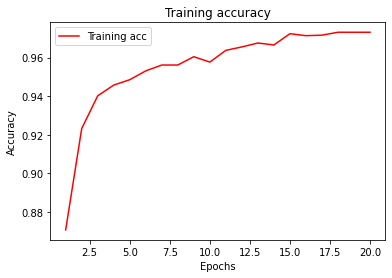

In [ ]:
# Plotting the training accuracy of trained model in graph

history_dict = history.history
acc_values = history_dict["accuracy"]
epochs = range(1, len(acc_values)+1)
plt.plot(epochs, acc_values, color="red", label="Training acc")
plt.title("Training accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# Step 13: Saving the model which is trained

model1.save('/content/drive/MyDrive/Research project 1/model1.h5')

In [7]:
# Step 14: Loading the saved model 

model1 = tf.keras.models.load_model('/content/drive/MyDrive/Research project 1/model1.h5')

In [8]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 768)]          0         
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 1)                 4609      
                                                                 
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Step 15: Validating the model by passing dev data (validation)

model1_score = model1.evaluate(dev_embed, dev_label, batch_size=128)

24/24 [==============================] - 0s 9ms/step - loss: 0.1594 - accuracy: 0.9409


In [9]:
# Step 16: Testing the model by passing test data

prediction = model1.predict(test_embed)
predict_binary_labels = list(map(lambda x: 0 if x<0.5 else 1, prediction))
print(predict_binary_labels[0:10])

predicted_labels = ["psych" if i==1 else "non-psych" for i in predict_binary_labels]
print(predicted_labels[0:10])

# Adding predicted_label column to the test dataset
test_df=pd.read_excel("/content/drive/MyDrive/Research project 1/test_df.xlsx")
test_df["predicted_label"] = predicted_labels
test_df["unmatched"] = ["matched" if i == j  else "unmatched" for i,j in zip(test_df["non-psych"],test_df["predicted_label"])]

# Calculating the test score of model1
final_score= len(test_df[test_df["unmatched"] == "matched"])/len(test_df["unmatched"])

# Printing the score & predicted labels result
print("Final accuracy score of model1: ", final_score)
print("Total no. of data in test dataset: ",len(test_df))
print("No. of data correctly predicted by model1: ", len(test_df[test_df["unmatched"] == "matched"]))
print("No. of data not correctly predicted by model1: ",len(test_df[test_df["unmatched"] == "unmatched"]))

# Saving the final output into exel file
test_df.to_excel('/content/drive/MyDrive/Research project 1/final_output_df.xlsx', index=False)

# Printing verbs which are not correctly predicted by the model during testing
temp_df=pd.DataFrame()
temp_df = test_df.loc[test_df["unmatched"] == "unmatched"]
temp_df = temp_df[["Verb"]]
    
vrb_unmtch_dct = temp_df["Verb"].value_counts().to_dict()
vrb_unmtch=str(vrb_unmtch_dct)
print("Below are the verbs & their counts for which model doesn't predict correct label during testing: ",vrb_unmtch)



93/93 [==============================] - 0s 2ms/step
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
['non-psych', 'psych', 'psych', 'psych', 'psych', 'psych', 'psych', 'psych', 'psych', 'psych']
Final accuracy score of model1:  0.9378378378378378
Total no. of data in test dataset:  2960
No. of data correctly predicted by model1:  2776
No. of data not correctly predicted by model1:  184
Below are the verbs & their counts for which model doesn't predict correct label during testing:  {'guttun': 22, 'zusetzen': 21, 'provozieren': 19, 'schwerfallen': 18, 'stören': 15, 'aufwühlen': 10, 'genügen': 10, 'beruhigen': 9, 'quälen': 8, 'überfordern': 6, 'widerstreben': 6, 'verwirren': 6, 'ausreichen': 5, 'schmeicheln': 5, 'aufstoßen': 5, 'bewegen': 3, 'ekeln': 2, 'gefallen': 2, 'bekümmern': 2, 'zermürben': 2, 'plagen': 1, 'entmutigen': 1, 'nahegehen': 1, 'bedrücken': 1, 'einleuchten': 1, 'verstören': 1, 'irritieren': 1, 'auffallen': 1}
